# Exploratory Data Analysis

## Data Load

In [1]:
#required imports for the data analysis
import sqlite3
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import seaborn as sns
import sklearn.preprocessing as prep
import sklearn.ensemble as emsemble
import sklearn.covariance as cov
import sklearn.neighbors as neighb
import statsmodels.api as statsm

In [2]:
#setup connection to the database

mypath=".\\data\\insurance.db"
conn=sqlite3.connect(mypath)
cursor=conn.cursor()

In [3]:
#Get information about tables from db
cursor.execute("SELECT sql FROM sqlite_master WHERE type='table';")
tables=pd.DataFrame(cursor.fetchall(), columns=[d[0] for d in cursor.description])

table_variables=[]
for i in tables.iloc[:,0]:
    table_variables.append([j.group().replace("\"", '') for j in re.finditer('\".*\"',i)])

table_variables

[['LOB',
  'index',
  'Customer Identity',
  'Premiums in LOB: Motor',
  'Premiums in LOB: Household',
  'Premiums in LOB: Health',
  'Premiums in LOB:  Life',
  'Premiums in LOB: Work Compensations'],
 ['Engage',
  'index',
  'Customer Identity',
  'First Policy´s Year',
  'Brithday Year',
  'Educational Degree',
  'Gross Monthly Salary',
  'Geographic Living Area',
  'Has Children (Y=1)',
  'Customer Monetary Value',
  'Claims Rate']]

## Data Assessment 

In [4]:
#Build Analytical Base Table (ABT)
abtquery="""SELECT e.'Customer Identity', e.'First Policy´s Year', e.'Brithday Year', e.'Educational Degree', 
            e.'Gross Monthly Salary', e.'Geographic Living Area', e.'Has Children (Y=1)', e.'Customer Monetary Value', 
            e.'Claims Rate', l.'Premiums in LOB: Motor', l.'Premiums in LOB: Household', l.'Premiums in LOB: Health', 
            l.'Premiums in LOB:  Life', l.'Premiums in LOB: Work Compensations'
            FROM LOB l, Engage e
            WHERE l.'Customer Identity'=e.'Customer Identity'"""
cursor.execute(abtquery)

#Variables alias
alias=["id","first_policy","birthday","education","salary","area","children","cmv","claims_r","motor","household","health","life","work_comp"]

df=pd.DataFrame(cursor.fetchall(), columns=alias)
conn.close()
df.head()

,id,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
0,1,1985.0,1982.0,2 - High School,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2,1981.0,1995.0,2 - High School,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4,1990.0,1981.0,3 - BSc/MSc,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5,1986.0,1973.0,3 - BSc/MSc,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [5]:
#Dimension of the dataset
df.shape

(10296, 14)

In [6]:
#Data types of the variables
df.dtypes

id                int64
first_policy    float64
birthday        float64
education        object
salary          float64
area            float64
children        float64
cmv             float64
claims_r        float64
motor           float64
household       float64
health          float64
life            float64
work_comp       float64
dtype: object

In [7]:
#Check if first_policy, birthday and salary are integers
for i in [df.first_policy.fillna(0), df.birthday.fillna(0), df.salary.fillna(0)]: #control for nans
    print(all(i.apply(lambda x: x.is_integer())))#will return True if all values of each series is an integer

True
True
True


In [8]:
#Correcting some data types
#"first_policy":int, "birthday":int, "salary":int, can't be converted due to NAs
df=df.astype({"area": object, "children": object})

In [9]:
#Get summary statistics from df
df.iloc[:,1:].describe(include='all')

,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
count,10266.000000,10279.000000,10279,10260.000000,10295.0,10275.0,10296.000000,10296.000000,10262.000000,10296.000000,10253.000000,10192.000000,10210.000000
unique,NaN,NaN,4,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,3 - BSc/MSc,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,4799,NaN,4145.0,7262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1991.062634,1968.007783,NaN,2506.667057,NaN,NaN,177.892605,0.742772,300.470252,210.431192,171.580833,41.855782,41.277514
std,511.267913,19.709476,NaN,1157.449634,NaN,NaN,1945.811505,2.916964,211.914997,352.595984,296.405976,47.480632,51.513572
min,1974.000000,1028.000000,NaN,333.000000,NaN,NaN,-165680.420000,0.000000,-4.110000,-75.000000,-2.110000,-7.000000,-12.000000
25%,1980.000000,1953.000000,NaN,1706.000000,NaN,NaN,-9.440000,0.390000,190.590000,49.450000,111.800000,9.890000,10.670000
50%,1986.000000,1968.000000,NaN,2501.500000,NaN,NaN,186.870000,0.720000,298.610000,132.800000,162.810000,25.560000,25.670000
75%,1992.000000,1983.000000,NaN,3290.250000,NaN,NaN,399.777500,0.980000,408.300000,290.050000,219.820000,57.790000,56.790000


In [10]:
#More info about df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
id              10296 non-null int64
first_policy    10266 non-null float64
birthday        10279 non-null float64
education       10279 non-null object
salary          10260 non-null float64
area            10295 non-null object
children        10275 non-null object
cmv             10296 non-null float64
claims_r        10296 non-null float64
motor           10262 non-null float64
household       10296 non-null float64
health          10253 non-null float64
life            10192 non-null float64
work_comp       10210 non-null float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.1+ MB


In [11]:
#Check duplicates
any(df.duplicated())

False

In [12]:
#Number of missing values in each feature
df.isna().sum()

id                0
first_policy     30
birthday         17
education        17
salary           36
area              1
children         21
cmv               0
claims_r          0
motor            34
household         0
health           43
life            104
work_comp        86
dtype: int64

In [13]:
#Frequencies of number of missing values across rows
df.isna().apply(lambda x:sum(x), axis=1).value_counts().sort_index()

0    9987
1     256
2      38
3       3
4      12
dtype: int64

In [14]:
#Define metric and non-metric datasets
metric_df= df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="float64"))]
non_metric_df= df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="object"))]

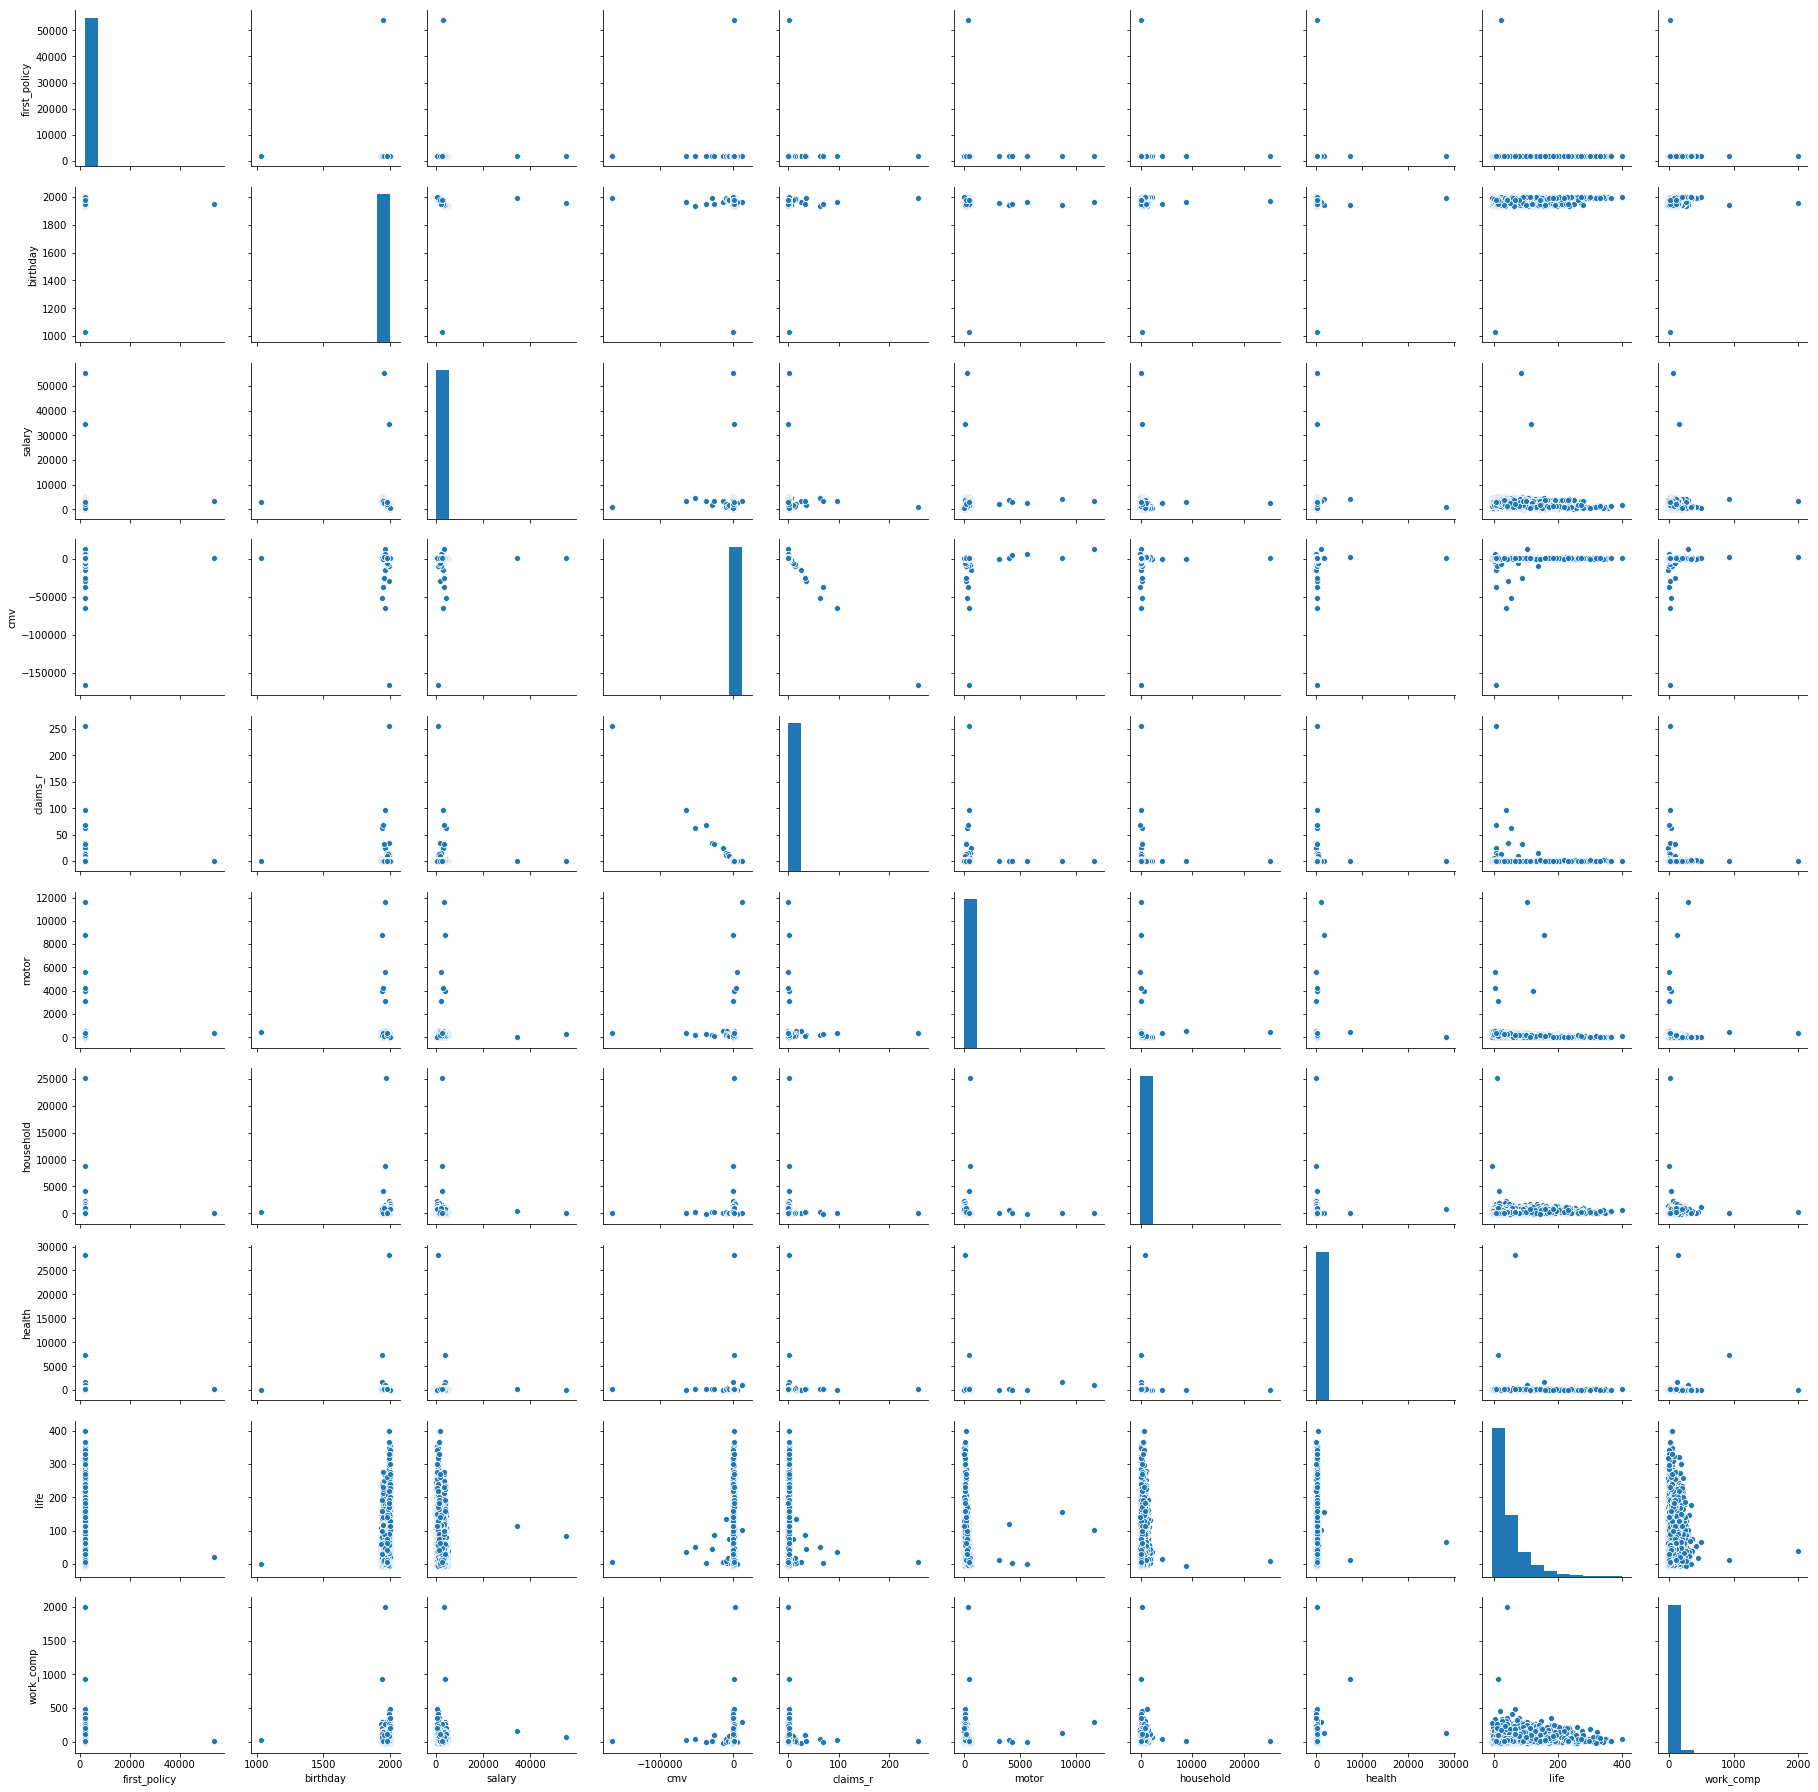

In [15]:
sns.pairplot(metric_df.drop("id",1).dropna()) #change number of bins in diagonal's scatter plots
plt.show()

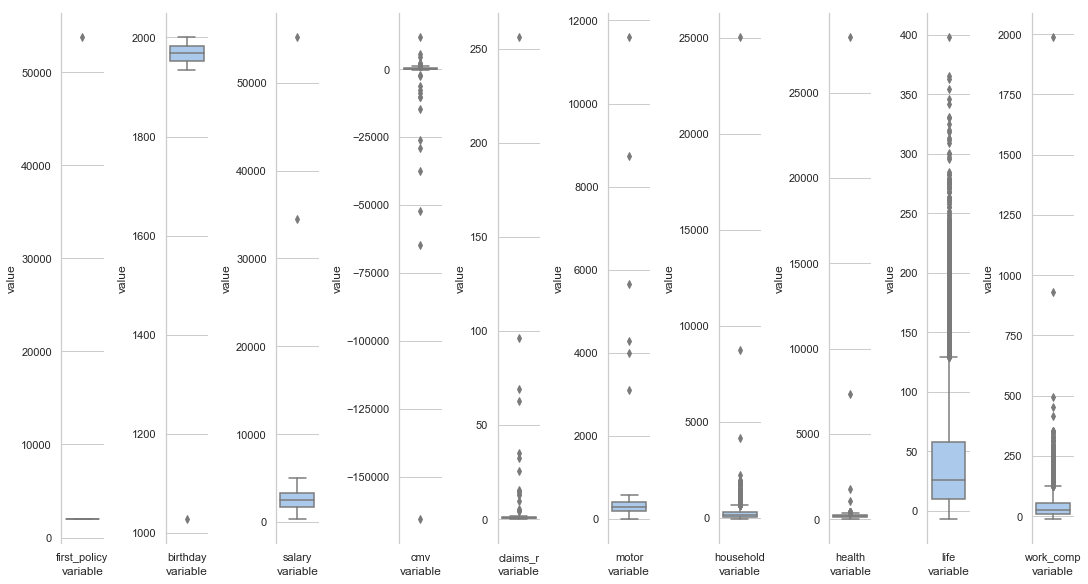

In [16]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Prepare dataframe layout
data=metric_df.melt("id")
plot_features= metric_df.drop("id",1).columns

#Prepare figure layout
fig= plt.figure(constrained_layout=True) #Create figure object
spec= gspec.GridSpec(ncols=len(plot_features), nrows=1, figure=fig) #Gridspec allows to define the grid structure which can  
                                                                    #then be populated through figure.add_subplot method
    
# Draw the violinplots and split the violins for easier comparison
for i, plot_f in enumerate(plot_features):
    ax= fig.add_subplot(spec[0,i])
    pdata= data.loc[data.loc[:,"variable"]==plot_f,:]
#     viol_df.loc[viol_df.loc[:,"variable"]==plot_f,:] #Selecting every variable-value pair for a specific metric variable
    graph= sns.boxplot(x="variable", y="value", data=pdata, ax=ax)

# Finalize the plot
sns.despine(bottom=True)
fig.set_size_inches(15, 8)

plt.show()

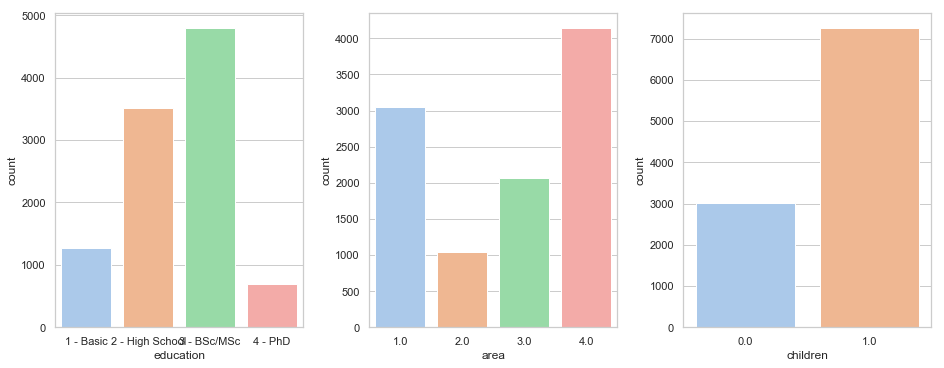

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(13,5))
gs = fig.add_gridspec(1, 3)

# fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(gs[0, 0]) # 1st to the before last row, 2nd column to last
ax2 = fig.add_subplot(gs[0, 1]) # 1st to the before last row, 1st column
ax3 = fig.add_subplot(gs[0, 2]) # last row, every column

sns.countplot(x="education", data=non_metric_df, ax=ax1, order=["1 - Basic", "2 - High School", "3 - BSc/MSc", "4 - PhD"])
sns.countplot(x="area", data=non_metric_df, ax=ax2)
sns.countplot(x="children", data=non_metric_df, ax=ax3)

plt.show()

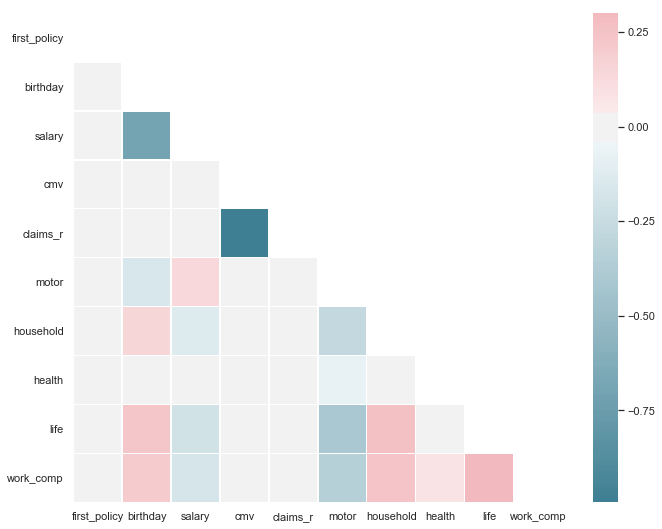

In [18]:
sns.set(style="white")

# Compute the correlation matrix
corr = metric_df.drop("id",1).corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5)

plt.show()

## Data cleaning

### Ideas
- see if mean of variables differs by area of living (t-test, pivot-table, ...)
- see the same for childs
- if cmv <0 and claims_r <1 then: bad customer (no pay); if cmv<0 and claims_r>1 then: prone to call insurance. Can we do thiss? claims_r is for the last 2 years and cmv is lifetime

### Coherence Checks
- first_policy >= birthday
- some constraint regarding age and education (e.g. people with phd should at least have more than 25 yo)?
- minors have children/ salary/ etc. but education remains as 1 - Basic?
- minors have motor insurance?


# Drop birthday variable! Professor said...

In [15]:
df.loc[df["first_policy"]==1998]

,id,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
23,24,1998.0,1961.0,2 - High School,2870.0,4,1,290.05,0.64,222.04,329.50,248.38,48.01,33.56
65,66,1998.0,1941.0,3 - BSc/MSc,3760.0,1,0,132.27,0.78,276.83,175.60,261.27,6.89,-6.11
279,280,1998.0,1938.0,1 - Basic,4386.0,1,0,193.04,0.79,96.02,541.20,189.59,127.69,90.35
506,507,1998.0,1942.0,1 - Basic,3743.0,1,0,-46.67,1.02,85.24,554.00,307.39,46.12,24.45
627,628,1998.0,1973.0,3 - BSc/MSc,2915.0,1,1,42.67,0.90,401.52,89.45,151.14,17.67,21.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9259,9260,1998.0,1987.0,2 - High School,1226.0,2,0,-87.23,1.09,333.73,92.80,77.68,70.57,84.46
9392,9393,1998.0,1960.0,2 - High School,2306.0,4,1,-85.01,1.09,161.14,106.70,156.03,181.48,60.01
9562,9563,1998.0,1997.0,1 - Basic,886.0,1,1,1369.70,0.09,32.45,1159.10,88.46,11.67,235.60
9768,9769,1998.0,1996.0,1 - Basic,972.0,1,1,1096.65,0.05,86.46,726.80,56.79,89.35,219.04


In [16]:
df.loc[df["motor"].isna()]

,id,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
184,185,1993.0,1984.0,2 - High School,2419.0,4,1,-62.23,1.07,NaN,253.95,230.60,5.89,43.12
488,489,1977.0,1947.0,3 - BSc/MSc,NaN,3,0,-52.56,1.09,NaN,0.00,278.83,NaN,27.56
516,517,1993.0,1986.0,3 - BSc/MSc,2047.0,4,1,226.49,0.62,NaN,304.50,239.49,53.01,62.01
862,863,1987.0,1981.0,3 - BSc/MSc,2127.0,1,1,-25.00,0.00,NaN,0.00,NaN,NaN,NaN
1133,1134,1974.0,1952.0,3 - BSc/MSc,3560.0,2,0,-25.00,0.00,NaN,0.00,NaN,NaN,NaN
1160,1161,1981.0,1983.0,3 - BSc/MSc,NaN,3,1,4.56,0.79,NaN,0.00,106.02,3.89,33.45
1333,1334,1989.0,1965.0,2 - High School,3136.0,1,1,32.01,0.55,NaN,29.45,69.79,16.78,10.78
1816,1817,1978.0,1959.0,3 - BSc/MSc,NaN,2,1,58.68,0.62,NaN,0.00,138.47,17.78,65.90
2458,2459,1992.0,1995.0,3 - BSc/MSc,1914.0,2,1,442.19,0.39,NaN,516.20,169.81,49.01,34.45
3165,3166,1995.0,1981.0,2 - High School,1813.0,4,1,-25.00,0.00,NaN,0.00,NaN,NaN,NaN


In [17]:
df.loc[(df["birthday"]>1998) & (df["children"]==1)] #the chidlren variable doesn't make a lot of sense. Is it a binary for having or not children? If so, why do we have minors with children?

,id,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
13,14,1983.0,2000.0,1 - Basic,1043.0,3,1,-75.12,1.06,44.34,342.85,127.69,267.94,94.46
186,187,1993.0,1999.0,1 - Basic,1247.0,2,1,-128.24,1.07,33.23,1026.30,82.57,75.68,212.15
397,398,1986.0,2000.0,1 - Basic,415.0,1,1,-218.48,1.22,52.01,348.40,49.01,193.48,225.82
480,481,1984.0,1999.0,1 - Basic,1581.0,4,1,866.27,0.21,30.34,683.45,98.13,71.68,249.16
526,527,1982.0,1999.0,1 - Basic,840.0,4,1,-23.54,1.00,132.69,165.60,137.36,129.69,164.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9936,9937,1989.0,1999.0,1 - Basic,918.0,3,1,738.24,0.20,29.45,457.85,117.69,275.94,78.35
9947,9948,1987.0,2000.0,1 - Basic,422.0,1,1,-145.58,1.07,36.23,1409.15,66.68,14.78,171.59
10043,10044,1983.0,1999.0,1 - Basic,1110.0,1,1,907.28,0.34,25.56,1011.85,120.80,144.25,105.13
10121,10122,1978.0,1999.0,1 - Basic,738.0,4,1,365.19,0.53,57.12,293.95,100.02,276.83,96.24


**Why is the first_policy less than birthday in some cases?**

1. Fraud 
2. Family policy where children are born after the policy
3. Company policy where employees are born after the policy
4. Claims: due to accident or injuries, a policy made with this company is paying for the treatment of a person younger than the policy origin.

In order to have a better way to distinguish these situations the company should had a column with the original owner of the policy, in order to track the origin.

Since we can't distinguish between these four situations, we will proceeed by replacing the first_policy value with the birthday year.

In [18]:
df.loc[df.first_policy<df.birthday]

,id,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
1,2,1981.0,1995.0,2 - High School,677.0,4,1,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
13,14,1983.0,2000.0,1 - Basic,1043.0,3,1,-75.12,1.06,44.34,342.85,127.69,267.94,94.46
18,19,1981.0,1982.0,1 - Basic,1414.0,3,1,230.38,0.71,313.17,373.40,121.80,14.78,72.57
22,23,1976.0,1986.0,2 - High School,1495.0,1,1,-89.79,1.08,209.04,308.95,192.48,64.79,54.90
40,41,1994.0,1995.0,2 - High School,1177.0,4,1,121.36,0.84,52.01,455.65,135.47,146.36,148.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10268,10269,1987.0,1988.0,3 - BSc/MSc,1414.0,3,1,50.46,0.90,129.58,167.80,184.48,165.92,75.46
10273,10274,1989.0,1992.0,2 - High School,1035.0,1,1,293.51,0.58,235.71,195.60,103.13,170.92,58.12
10284,10285,1980.0,1987.0,3 - BSc/MSc,1504.0,4,1,-1.55,0.96,390.63,29.45,179.70,-6.00,NaN
10288,10289,1982.0,1993.0,2 - High School,1465.0,1,1,795.15,0.35,67.79,820.15,102.13,182.48,86.46


In [19]:
df.groupby("birthday").mean().salary #minors have salary?

birthday
1028.0    2830.000000
1935.0    4069.857143
1936.0    4074.378378
1937.0    3989.877193
1938.0    4008.857143
             ...     
1997.0     994.431818
1998.0     950.787234
1999.0     990.289855
2000.0     928.885714
2001.0    1017.916667
Name: salary, Length: 68, dtype: float64

### Outliers

We will divide the outlier dection procedure into **parametric** and **non-parametric** approaches.

We will use methods such as the interquantile range, standard deviation, qq-plots, isolation trees, mahalanobis distance (chi-square plots) and local outlier factor (LOF).

In order to apply some of the methods proposed we will need to map our variables to a **normal distribution**. 

The end goal of this analysis is to end up with a outlier identificator column for each method and then decide which observations to exclude based on this.

**References:** https://scikit-learn.org/stable/modules/outlier_detection.html, https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html#sphx-glr-auto-examples-covariance-plot-mahalanobis-distances-py, https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html, https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate

#### Apriori analysis

From the boxplots and scatter plots above we can visualize the presence of observations with values that are logically invalid ans should be eliminated:
* first_policy values above 50000 (we are in 2019);
* birthday values below 1200 (there was no insurance companies in 1200);

In [20]:
df=df.loc[(df["first_policy"]!=53784.0) & (df["birthday"]!=1028.0)] # we have to select the exact value otherwise we will eliminate nans

#Define metric and non-metric datasets
metric_df= df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="float64"))]
non_metric_df= df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="object"))]

#### Normal distribution transformations

There are three common approaches to make data more Gaussian-like, Box-Cox, Yeo-Johnson and Quantile transformations. However, Box-Cox requires input data to be strictly positive, for that reason we will apply all the transformations whenever possible, and then compare the normality fit through the use of QQ-plots.

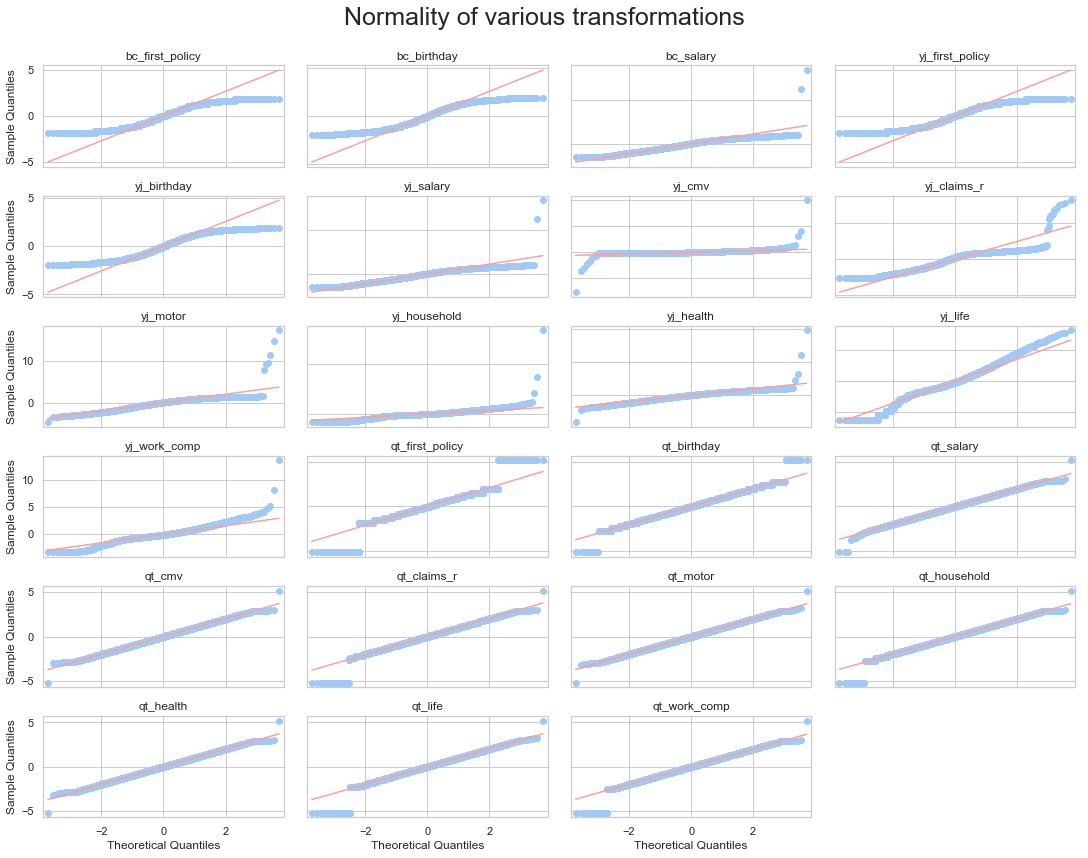

In [110]:
data=metric_df.set_index("id")
mask= data.apply(lambda x: np.any(x<=0), axis=0)
labels= mask.index[mask==False].to_list() #getting stricly positive columns for BoxCox transformation

# Transformations
rng = np.random.RandomState(304)
bc= prep.PowerTransformer(method='box-cox')
yj= prep.PowerTransformer(method='yeo-johnson')
qt= prep.QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=rng)

# Perform power transforms and quantile transform
X_trans_bc= bc.fit_transform(data[labels])
X_trans_yj= yj.fit_transform(data)
X_trans_qt= qt.fit_transform(data)

# Merging
X_trans= np.concatenate((X_trans_bc, X_trans_yj, X_trans_qt), axis=1)

# Creating DataFrame
merge_labels=list(map(lambda x: "bc_" + x, labels))+list(map(lambda x: "yj_" + x, data.columns.to_list()))+list(map(lambda x: "qt_" + x, data.columns.to_list()))
trans_df=pd.DataFrame(X_trans, columns=merge_labels, index=data.index)

# Dealing with nans
trans_df.fillna(trans_df.median(), inplace=True)

# Plot transformed data
fig, axes = plt.subplots(6,4, constrained_layout=True, figsize=(15,12))

fig.suptitle("Normality of various transformations\n", fontsize=25)

for col, ax in zip(trans_df.columns, axes.flatten()):
    x=trans_df.loc[:,col]
    statsm.qqplot(x, line="q", ax=ax)
#     sns.distplot(x, ax=ax, kde=False)
    ax.set_title(col)
    
# Deleting left out axis (24th)
fig.delaxes(axes.flatten()[23])

# Just appear labels on outside axes
for ax in fig.get_axes():
    ax.label_outer()

plt.show()

The fit of the transformation to a Normal Distribution can be seen through the allignment of the points over the red line, which displays the behaviour or the points in case of perfect fit. As both the Quantile and Yeo-Johnson transformations provide gaussian-like distributions, we will use both to apply the parametric tests for outlier detection.

#### Univariate Outliers

In [22]:
transqt_df=trans_df.loc[:,[i for i in trans_df.columns.to_list() if "qt" in i]]
transyj_df=trans_df.loc[:,[i for i in trans_df.columns.to_list() if "yj" in i]]

In [77]:
def out_std(data, nstd=3.0, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series using standard deviation, works column-wise.
    param nstd:
        Set number of standard deviations from the mean to consider an outlier
    :type nstd: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    data_mean, data_std = data.mean(), data.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return data.apply(lambda x: np.any((x<lower) | (x>upper)), 1)

def out_iqr(data, k=1.5, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series using interquartile range, works column-wise.
    param k:
        some cutoff to multiply by the iqr
    :type k: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    # calculate interquartile range
    q25, q75 = np.percentile(data, 25, axis=0), np.percentile(data, 75, axis=0)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return data.apply(lambda x: np.any((x<lower) | (x>upper)), 1)

In [105]:
outyjstd, outyjiqr, outqtstd, outqtiqr = out_std(transyj_df), out_iqr(transyj_df, 2), out_std(transqt_df), out_iqr(transqt_df, 2)

In [168]:
#Isolation Forest
data.fillna(data.median(), inplace=True)
if_out=emsemble.IsolationForest(contamination="auto", behaviour="new").fit(data)
outdataif=if_out.predict(data)

#### Multivariate Outliers

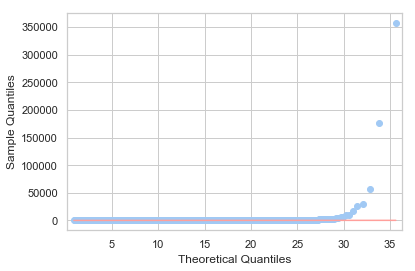

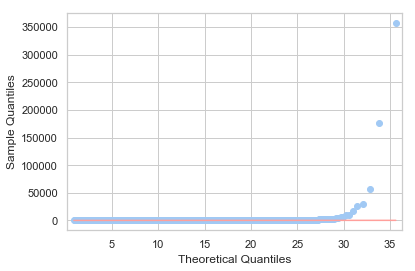

In [166]:
ee_out = cov.EllipticEnvelope(contamination=0.05).fit(transyj_df)
outyjee = ee_out.predict(transyj_df)
import scipy.stats as stats
statsm.qqplot(ee_out.mahalanobis(transyj_df), dist=stats.chi2, distargs=(10,), line="q")

In [178]:
lof_out = neighb.LocalOutlierFactor(contamination="auto")
outyjlof = lof_out.fit_predict(transyj_df)

### Missing Values

# Dealing with Categorical Variables

In the particular case of education, since there's an inherent order in its scale, we will consider it as a metric variable.
* **We could use years of education instead, since the difference between basic and high school is different from the one between PhD and BSc/MSc**

In [90]:
df["educ_code"]=pd.to_numeric(df["education"].apply(lambda x: x[0] if x!=None else None))

0        2.0
1        2.0
2        1.0
3        3.0
4        3.0
        ... 
10291    4.0
10292    1.0
10293    3.0
10294    1.0
10295    4.0
Name: educ_code, Length: 10296, dtype: float64

## Feature Engineering
- Years as customer (YC)
- Years old (YO)
- YC/YO
- CMV/YC
- Total premiums
- Each premium/Total premiums
- Number of products= Number of non-zero premium columns

In [7]:
current_year=2016
years_customer= current_year-df.first_policy
age= current_year-df.birthday
years_customer_age= years_customer/age
cmv_years_customer= df.cmv/years_customer
t_premiums= df.loc[:,["motor","household","health","life","work_comp"]].apply(sum, axis=1)
perc_premiums= [df.loc[:,i]/t_premiums for i in ["motor","household","health","life","work_comp"]]

# Clustering

For mixed data types use k-prototypes? to merge metric and non-metric clustering. DONT'T USE FOR EXAMPLE K-MEANS WITH ONE-HOT ENCODED NON-METRIC VARIABLES (TEACHER DOESN'T LIKE IT AND IT DOESN'T MAKE SENSE TO CALCULATE DISTANCE BETWEEN NON-METRIC VARIABLES)